<a href="https://colab.research.google.com/github/okcdbu/KNNClustering/blob/main/metro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 사전 라이브러리 임포트

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 1. 데이터 로드

In [3]:
data_path = "./seoulsubway.csv"  # 데이터 파일 경로 설정
data = pd.read_csv(data_path, encoding='euc-kr')

In [4]:
# 데이터 확인
print("데이터 샘플:")
print(data.head())

데이터 샘플:
      사용월  호선명 지하철역  04시-05시 승차인원  04시-05시 하차인원  05시-06시 승차인원  05시-06시 하차인원  \
0  202411  1호선  동대문           590            18         11507          1945   
1  202411  1호선  동묘앞           180             1          2890           959   
2  202411  1호선  서울역           619            19          8411          8848   
3  202411  1호선   시청            71             0          2029          5239   
4  202411  1호선  신설동           385            21          9307          2313   

   06시-07시 승차인원  06시-07시 하차인원  07시-08시 승차인원  ...  23시-24시 하차인원  00시-01시 승차인원  \
0          9996          6511         16584  ...          9536           869   
1          3755          5025          9119  ...          4506           137   
2         13670         58234         42622  ...         14302          3414   
3          3818         27038          7955  ...          3948           575   
4         10188          9168         22551  ...          9065           426   

   00시-01시 하차인원  01시-02시 승차인원  01시-0

### 2. 데이터 전처리

In [14]:
# 호선명, 지하철역, 사용월을 합쳐 새로운 열 생성
data['UniqueID'] = data['사용월'].astype(str) + data['호선명'] + data['지하철역']
data.set_index('UniqueID', inplace=True)

### 3. 데이터 스케일링

In [18]:
data_filtered = data.filter(like="승차인원")
label_encoder = LabelEncoder()
data['호선명_encoded'] = label_encoder.fit_transform(data['호선명'])
data['지하철역_encoded'] = label_encoder.fit_transform(data['지하철역'])

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filtered)

### 4. KNN 군집화 (K-Means 사용)

In [19]:
# 최적의 클러스터 개수 찾기 (엘보우 기법)
inertia = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

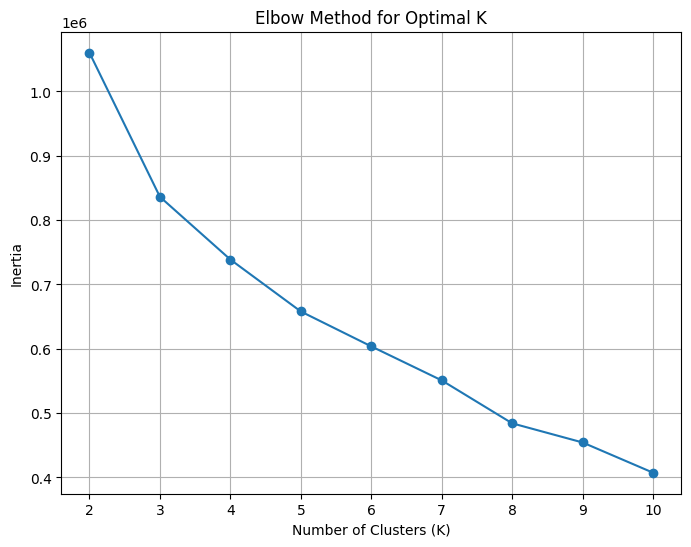

In [20]:
# 엘보우 기법 시각화
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

기울기가 완만하게 변하는 특정 지점을 관찰하여 최적의 클러스터 수를 선택

In [21]:
# 최적 클러스터 수 선택 (예: K=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(data_scaled)

KMeans(n_clusters=3, random_state=42)

### 5. 결과 분석

In [22]:
# 군집 라벨 추가
data_filtered['Cluster'] = kmeans.labels_

# 군집별 특성 분석
cluster_summary = data_filtered.groupby('Cluster').mean()
print("군집별 평균 특성:")
print(cluster_summary)

군집별 평균 특성:
         04시-05시 승차인원  05시-06시 승차인원  06시-07시 승차인원  07시-08시 승차인원  08시-09시 승차인원  \
Cluster                                                                         
0          105.085304   2906.335518   6369.470059  16005.875206  17237.629020   
1          789.834415  14932.883225  25043.376583  63721.472042  85156.974977   
2          357.124356   9092.928468  18647.195011  48680.751288  55649.882808   

         09시-10시 승차인원  10시-11시 승차인원  11시-12시 승차인원  12시-13시 승차인원  13시-14시 승차인원  \
Cluster                                                                         
0        10520.333222   8040.537434   7962.154349   8530.537017   8604.301142   
1        61215.139635  49358.995984  54072.216559  61760.611986  69732.299969   
2        34449.666924  25732.313544  25541.463925  27716.406926  28641.731911   

         ...   18시-19시 승차인원   19시-20시 승차인원  20시-21시 승차인원  21시-22시 승차인원  \
Cluster  ...                                                             
0        ...   16610.830707  

<ipython-input-22-24bad0a32b38>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Cluster'] = kmeans.labels_


### 6. 배차 간격 계산

In [13]:
# 시간대 열 추출 (마지막 'Cluster' 제외)
time_columns = data_filtered.columns[:-1]

# 배차 간격 계산 함수
def calculate_interval(passenger_count):
    if passenger_count >= 1000:
        return 5  # 5분 간격
    elif passenger_count >= 500:
        return 10  # 10분 간격
    else:
        return 15  # 15분 간격

# 군집별 시간대별 배차 간격 계산
interval_recommendation = cluster_summary.applymap(calculate_interval)

print("군집별 시간대 배차 간격 추천 (분 단위):")
print(interval_recommendation)

# 결과 저장
interval_recommendation.to_csv("recommended_intervals.csv")
print("추천 배차 간격이 recommended_intervals.csv에 저장되었습니다.")

군집별 시간대 배차 간격 추천 (분 단위):
         04시-05시 승차인원  05시-06시 승차인원  06시-07시 승차인원  07시-08시 승차인원  08시-09시 승차인원  \
Cluster                                                                         
0                  15             5             5             5             5   
1                  10             5             5             5             5   
2                  15             5             5             5             5   

         09시-10시 승차인원  10시-11시 승차인원  11시-12시 승차인원  12시-13시 승차인원  13시-14시 승차인원  \
Cluster                                                                         
0                   5             5             5             5             5   
1                   5             5             5             5             5   
2                   5             5             5             5             5   

         ...  18시-19시 승차인원  19시-20시 승차인원  20시-21시 승차인원  21시-22시 승차인원  \
Cluster  ...                                                           
0        ...       

<ipython-input-13-4ddcdf898b80>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  interval_recommendation = cluster_summary.applymap(calculate_interval)


### 7. 시각화

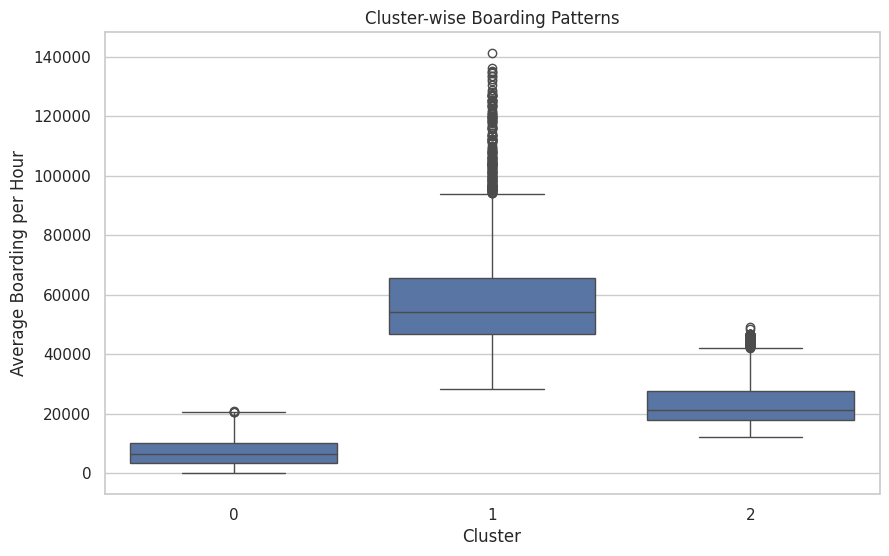

In [23]:
# 군집별로 역의 승객 패턴 시각화
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_filtered['Cluster'], y=data_filtered.mean(axis=1))
plt.title("Cluster-wise Boarding Patterns")
plt.xlabel("Cluster")
plt.ylabel("Average Boarding per Hour")
plt.show()


### 8. 결과 저장

In [ ]:
data_filtered.reset_index(inplace=True)
result_file = "clustered_subway_data.csv"
data_filtered.to_csv(result_file, index=False)
print(f"군집화 결과가 {result_file}에 저장되었습니다.")